In [1]:
# import all tensor flow and cv2 libraries/ layers

import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import numpy as np
import random
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model


2025-04-30 01:18:31.378548: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-30 01:18:31.386428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745965111.395725 4172416 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745965111.398447 4172416 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-30 01:18:31.407930: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import tensorflow as tf
print(tf.sysconfig.get_build_info())


OrderedDict({'cpu_compiler': '/usr/lib/llvm-18/bin/clang', 'cuda_compute_capabilities': ['sm_60', 'sm_70', 'sm_80', 'sm_89', 'compute_90'], 'cuda_version': '12.5.1', 'cudnn_version': '9', 'is_cuda_build': True, 'is_rocm_build': False, 'is_tensorrt_build': False})


In [3]:
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
train_path = '/home/group02-f24/Documents/Abdelmohsen/Thesis/FER/Datasets/AffectNet/train'
test_path = '/home/group02-f24/Documents/Abdelmohsen/Thesis/FER/Datasets/AffectNet/test'
Validation_path = '/home/group02-f24/Documents/Abdelmohsen/Thesis/FER/Datasets/AffectNet/val'

In [5]:
emotionsAvailable = ['neutral', 'happy', 'sad', 'disgust', 'fear', 'anger']
emotionMapping = {'0': 'anger','1': 'fear','2': 'happy', '3': 'sad', '4': 'Disgust', '5': 'neutral'}
len(emotionsAvailable)

6

In [19]:
reversedMapping = {v: k for k, v in emotionMapping.items()}
randomemotion = random.choice(emotionsAvailable)
temp = randomemotion
randomemotion = str(reversedMapping[randomemotion])

In [20]:
path = train_path + '/' + randomemotion
imagesPath = os.listdir(path)

(1095, 1095, 3)

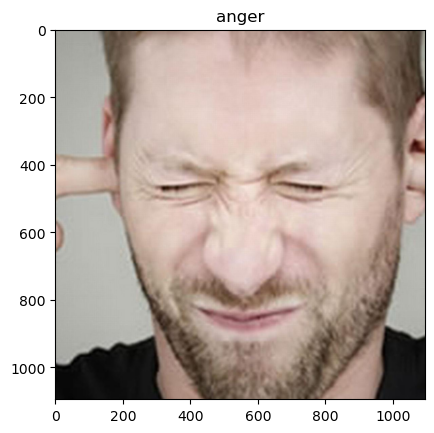

In [21]:
imagesPath[1]
img = cv2.imread(path + '/' + imagesPath[1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(temp)
img.shape


In [33]:
TrainDataGen = ImageDataGenerator(rescale=1.0/255, zoom_range=0.2, shear_range=0.2, horizontal_flip=True, vertical_flip=True)
TrainGen = TrainDataGen.flow_from_directory(train_path, target_size=(224,224), color_mode='rgb',batch_size=64, class_mode='categorical', shuffle=True)

Found 28803 images belonging to 6 classes.


In [34]:
TestDataGen = ImageDataGenerator(rescale=1.0/255)
TestGen = TestDataGen.flow_from_directory(test_path, target_size=(224,224), color_mode='rgb', batch_size=64, class_mode='categorical', shuffle=True)

Found 2400 images belonging to 6 classes.


In [35]:
ValidDataGen = ImageDataGenerator(rescale=1.0/255)
ValidGen = ValidDataGen.flow_from_directory(Validation_path, target_size=(224,224), color_mode='rgb', batch_size=64, class_mode='categorical', shuffle=True)

Found 600 images belonging to 6 classes.


In [36]:

l2_strength = 0.01 

model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(1024, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)))
model.add(Dense(6, activation='softmax'))  # Output layer



/home/group02-f24/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:

initial_learning_rate = 0.0075  # Starting LR
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1500, decay_rate=0.95, staircase=True
)
optimizer = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 222, 222, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 109, 109, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 109, 109, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 52, 52, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 52, 52, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 10, 10, 1024)   │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 10, 10, 1024)   │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 5, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 5, 5, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,276,928 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,723,142 (37.09 MB)

 Trainable params: 9,719,174 (37.08 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [39]:

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/home/group02-f24/Documents/Abdelmohsen/Thesis/FER/Models/AffectNet/AffectNet_NoSC_S224.keras",  
    monitor="val_loss",           
    save_best_only=True,          
    mode="min",                   
    verbose=1                     
)

In [40]:
hist = model.fit(TrainGen,validation_data=ValidGen, epochs=100, callbacks=[checkpoint_callback], verbose=1)

/home/group02-f24/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100


I0000 00:00:1745965320.680673 4172748 service.cc:148] XLA service 0x7f05980026e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745965320.680698 4172748 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-04-30 01:22:00.722678: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745965320.831608 4172748 cuda_dnn.cc:529] Loaded cuDNN version 90600
2025-04-30 01:22:01.919653: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4042', 448 bytes spill stores, 448 bytes spill loads

2025-04-30 01:22:02.058703: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4045', 440 by

  2/451 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - accuracy: 0.1367 - loss: 9.7542   

I0000 00:00:1745965331.168466 4172748 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.2069 - loss: 7.6216
Epoch 1: val_loss improved from inf to 3.77846, saving model to /home/group02-f24/Documents/Abdelmohsen/Thesis/FER/Models/AffectNet/AffectNet_NoSC_S224.keras
451/451 ━━━━━━━━━━━━━━━━━━━━ 158s 325ms/step - accuracy: 0.2069 - loss: 7.6182 - val_accuracy: 0.2250 - val_loss: 3.7785
Epoch 2/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.2916 - loss: 3.1931
Epoch 2: val_loss improved from 3.77846 to 2.11267, saving model to /home/group02-f24/Documents/Abdelmohsen/Thesis/FER/Models/AffectNet/AffectNet_NoSC_S224.keras
451/451 ━━━━━━━━━━━━━━━━━━━━ 133s 296ms/step - accuracy: 0.2916 - loss: 3.1922 - val_accuracy: 0.3633 - val_loss: 2.1127
Epoch 3/100
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.3722 - loss: 2.0036
Epoch 3: val_loss improved from 2.11267 to 1.62170, saving model to /home/group02-f24/Documents/Abdelmohsen/Thesis/FER/Models/AffectNet/AffectNet_NoSC_S224.keras
451/451 ━━━━━━━━━━━━━

In [ ]:
# model.save('/home/group02-f24/Documents/Abdelmohsen/Thesis/FER/Models/AffectNet/AffectNet_NoSC3.keras')

In [13]:
model = load_model('/home/group02-f24/Documents/Abdelmohsen/Thesis/FER/Models/AffectNet/AffectNet_NoSC_GrayScale.keras')

I0000 00:00:1745337679.124859 1695074 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 662 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [41]:
model.predict(TestGen)

38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step


array([[8.64571892e-03, 2.80820966e-01, 1.22321141e-03, 5.33208430e-01,
        3.82856489e-03, 1.72273114e-01],
       [8.67712438e-01, 1.33167915e-02, 2.31781625e-03, 2.56161019e-02,
        5.99461123e-02, 3.10907364e-02],
       [6.82986379e-02, 4.50471509e-03, 3.42712575e-03, 4.53628540e-01,
        3.75439809e-03, 4.66386586e-01],
       ...,
       [2.73599313e-03, 9.92836535e-01, 3.41816200e-03, 6.76566327e-04,
        1.80795760e-04, 1.51840170e-04],
       [4.47708322e-03, 3.61678421e-01, 9.70283232e-04, 5.78090012e-01,
        4.86038439e-02, 6.18039584e-03],
       [1.69155911e-01, 7.93926597e-01, 3.41932848e-02, 5.49005403e-04,
        1.96957239e-03, 2.05675286e-04]], dtype=float32)

In [42]:
model.evaluate(TestGen)

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.6398 - loss: 1.1359


[1.1536167860031128, 0.6395833492279053]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


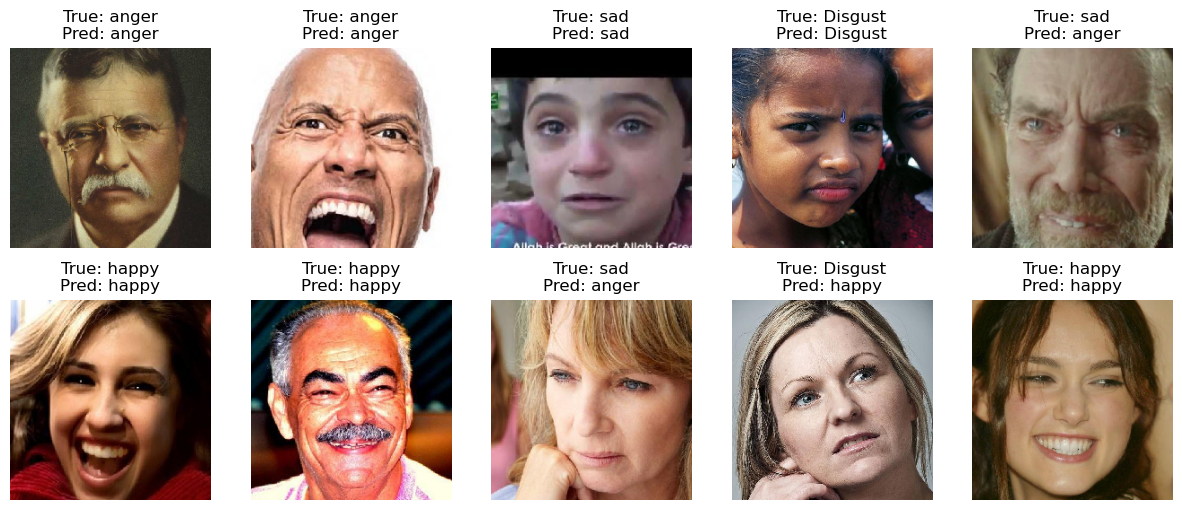

In [44]:
batch_images, batch_labels = next(TestGen)
ypred = model.predict(batch_images)
ypred = np.argmax(ypred, axis=1)
batch_labels = np.argmax(batch_labels, axis=1)
batch_labels = [emotionMapping[str(i)] for i in batch_labels]
ypred = [emotionMapping[str(i)] for i in ypred]  # ✅ Correct
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(batch_images[i])  # Already rescaled to [0,1]
    plt.title(f"True: {batch_labels[i]}\nPred: {ypred[i]}")
    plt.axis("off")

In [ ]:
type(emotionMapping)

dict

In [ ]:
# model.save('/home/group02-f24/Documents/Abdelmohsen/Thesis/FER/Models/AffectNetmodel_6.h5')
# model.save_weights('/home/group02-f24/Documents/Abdelmohsen/Thesis/FER/Weights/AffectNet_model_6.weights.h5')

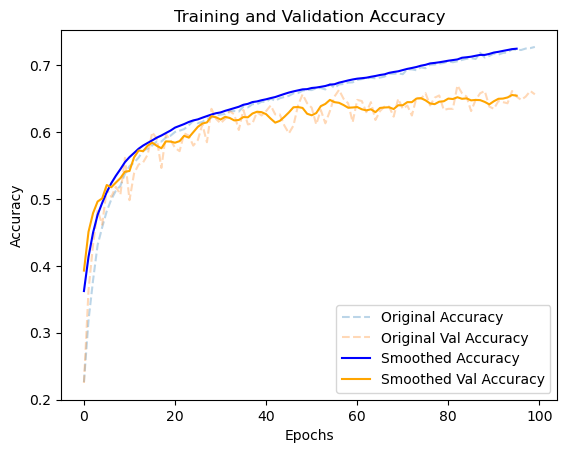

In [45]:

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Extract history
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# Smooth values
smoothed_acc = moving_average(acc, window_size=5)
smoothed_val_acc = moving_average(val_acc, window_size=5)

# Plot original and smoothed curves
plt.plot(acc, alpha=0.3, label='Original Accuracy', linestyle='dashed')
plt.plot(val_acc, alpha=0.3, label='Original Val Accuracy', linestyle='dashed')
plt.plot(range(len(smoothed_acc)), smoothed_acc, label='Smoothed Accuracy', color='blue')
plt.plot(range(len(smoothed_val_acc)), smoothed_val_acc, label='Smoothed Val Accuracy', color='orange')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


# *Loading The Model*

In [29]:
model.evaluate(TestGen)

/home/group02-f24/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-04-22 18:05:05.585801: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 156.31MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-22 18:05:05.585836: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 156.31MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more 

222/224 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6676 - loss: 0.9306

2025-04-22 18:05:17.526770: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_229', 12 bytes spill stores, 12 bytes spill loads

2025-04-22 18:05:17.654343: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_248', 12 bytes spill stores, 12 bytes spill loads

2025-04-22 18:05:17.752231: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 149.74MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-04-22 18:05:17.752265: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 149.74MiB with freed_by_count=0. The caller indicates that this is 

224/224 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.6676 - loss: 0.9305


[0.9235007166862488, 0.6704807281494141]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


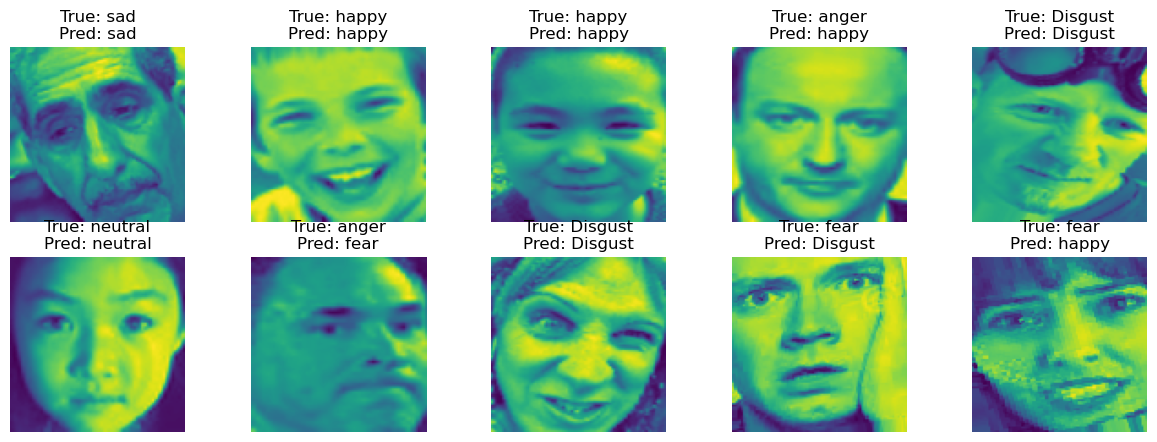

In [36]:
batch_images, batch_labels = next(TestGen)
ypred = model.predict(batch_images)
ypred = np.argmax(ypred, axis=1)
batch_labels = np.argmax(batch_labels, axis=1)
batch_labels = [emotionMapping[str(i)] for i in batch_labels]
ypred = [emotionMapping[str(i)] for i in ypred]  # ✅ Correct
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(batch_images[i])  # Already rescaled to [0,1]
    plt.title(f"True: {batch_labels[i]}\nPred: {ypred[i]}")
    plt.axis("off")

In [49]:
img = cv2.imread("/home/group02-f24/Desktop/pics/smile.jpeg")
img = cv2.resize(img, (224, 224))
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img = np.expand_dims(img, axis=-1)
img = np.expand_dims(img, axis=0)

[ WARN:0@38784.794] global loadsave.cpp:241 findDecoder imread_('/home/group02-f24/Desktop/pics/smile.jpeg'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [40]:
print(model.input_shape)


(None, 96, 96, 1)


In [41]:
model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


array([[3.3641324e-13, 1.0000000e+00, 1.7516231e-43, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [ ]:
img = cv2.imread("/home/group02-f24/Desktop/happy.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img = cv2.resize(img, (96, 96))  # Resize to match model input size
img = np.expand_dims(img, axis=0)  # Add batch dimension
img = img.astype('float32') / 255.0  # Normalize if needed

In [ ]:
model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


array([[0.71661454, 0.08696761, 0.02944914, 0.04726615, 0.06508341,
        0.05461916]], dtype=float32)

: 